# Jonathan Halverson
# Keeping it Fresh: Predict Restaurant Inspections
## Part 3: Yelp check-in data

In this notebook we attempt to find something useful in the check-in data. Nothing useful is found. We did attempt to deduce the size of each restaurant by summing the number of people checked-in. We also looked for a correlation between weighted violations and total number of check-ins (or effective size) but no correlation was found. This data set will be ignored in building the model.

Here is the format of the data:

{
    'type': 'checkin',
    'business_id': (business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from helper_methods import read_json
df_chk = read_json('data/yelp_academic_dataset_checkin.json')
df_chk.head(3)

,business_id,checkin_info,type
0,CgdK8DiyX9Y4kTKEPi_qgA,"{u'9-0': 2, u'11-1': 1, u'11-0': 2, u'11-2': 1...",checkin
1,SAnMTC1rm-PhP8DQC4zeyg,"{u'12-4': 1, u'13-2': 1, u'12-3': 1, u'12-0': ...",checkin
2,75dtVyDb8Sfwb7dR0cBvdg,"{u'7-0': 1, u'8-5': 2, u'8-0': 3, u'7-4': 4, u...",checkin


In [3]:
df_chk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1632 entries, 0 to 1631
Data columns (total 3 columns):
business_id     1632 non-null object
checkin_info    1632 non-null object
type            1632 non-null object
dtypes: object(3)
memory usage: 51.0+ KB


All the business id's are unique:

In [12]:
df_chk.business_id.unique().size

1632

In [4]:
def sum_checkins(day_index, dct):
    return sum([value for key, value in dct.iteritems() if '-' + str(day_index) in key])

In [5]:
dayofweek = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
for i, day in enumerate(dayofweek):
    df_chk[day + '_checkins'] = df_chk.checkin_info.apply(lambda d: sum_checkins(i, d))
df_chk['total_checkins'] = df_chk.checkin_info.apply(lambda d: sum(d.values()))
df_chk['num_bins'] = df_chk.checkin_info.apply(len)

The num_bins quantity can be at most 168 which is the number of hours in a week.

In [6]:
df_chk.head(3)

,business_id,checkin_info,type,sunday_checkins,monday_checkins,tuesday_checkins,wednesday_checkins,thursday_checkins,friday_checkins,saturday_checkins,total_checkins,num_bins
0,CgdK8DiyX9Y4kTKEPi_qgA,"{u'9-0': 2, u'11-1': 1, u'11-0': 2, u'11-2': 1...",checkin,14,16,12,12,10,1,0,65,28
1,SAnMTC1rm-PhP8DQC4zeyg,"{u'12-4': 1, u'13-2': 1, u'12-3': 1, u'12-0': ...",checkin,34,26,28,27,22,1,0,138,39
2,75dtVyDb8Sfwb7dR0cBvdg,"{u'7-0': 1, u'8-5': 2, u'8-0': 3, u'7-4': 4, u...",checkin,13,12,13,13,28,18,0,97,41


In [7]:
df_chk.describe()

,sunday_checkins,monday_checkins,tuesday_checkins,wednesday_checkins,thursday_checkins,friday_checkins,saturday_checkins,total_checkins,num_bins
count,1632.000000,1632.000000,1632.000000,1632.000000,1632.000000,1632.000000,1632.000000,1632.000000,1632.000000
mean,21.030637,20.989583,22.412377,25.029412,34.827819,42.710172,30.297181,197.297181,48.734681
std,34.016464,31.103345,33.387103,37.363055,53.697364,72.157289,57.267959,306.817881,30.747744
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
25%,3.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,30.000000,22.000000
50%,10.000000,10.000000,11.000000,12.000000,16.000000,17.000000,11.000000,95.500000,46.000000
75%,25.000000,26.000000,27.000000,31.000000,43.000000,52.000000,35.000000,239.250000,73.000000
max,552.000000,445.000000,406.000000,570.000000,844.000000,1253.000000,1052.000000,5122.000000,151.000000


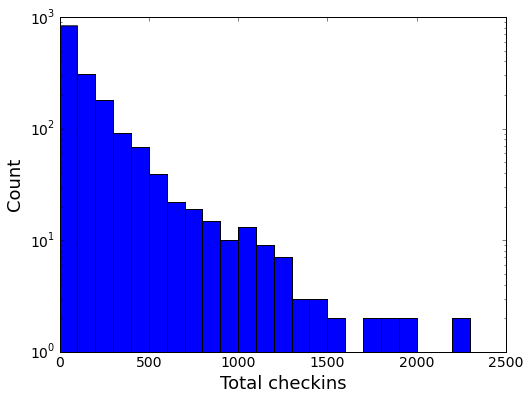

In [8]:
plt.hist(df_chk.total_checkins, bins=25, range=(0, 2500), log=True)
plt.xlabel('Total checkins')
plt.ylabel('Count')

### Let's see if total check-ins correlates with weighted violations

In [9]:
df = pd.read_csv('data/training_labels.txt')
df['weighted_violations'] = 1 * df['*'] + 3 * df['**'] + 5 * df['***']
df.head()

,id,date,restaurant_id,*,**,***,weighted_violations
0,589,2010-02-02,KAoKWjog,3,0,1,8
1,28589,2009-12-10,p038M4om,2,0,0,2
2,31170,2008-07-16,B1oXymOV,4,0,0,4
3,2600,2015-01-30,m0oWJl3G,1,0,3,16
4,1016,2012-03-19,rJoQwlEV,0,0,0,0


In [17]:
avg_violations = df.groupby('restaurant_id').agg({'*': [np.size, np.mean, np.sum], '**': [np.mean, np.sum], '***': [np.mean, np.sum], 'weighted_violations': [np.mean, np.sum]})
avg_violations.head(3)

weighted_violations         *                      ***      \
                             mean  sum size      mean  sum      mean sum   
restaurant_id                                                              
0ZED0WED                12.958333  311   24  4.416667  106  1.208333  29   
0ZED1B3D                 7.461538   97   13  2.846154   37  0.692308   9   
0ZED4ED9                 8.125000   65    8  5.000000   40  0.625000   5   

                     **      
                   mean sum  
restaurant_id                
0ZED0WED       0.833333  20  
0ZED1B3D       0.384615   5  
0ZED4ED9       0.000000   0

In [23]:
avg_violations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1851 entries, 0ZED0WED to ydEjz7EW
Data columns (total 9 columns):
(weighted_violations, mean)    1851 non-null float64
(weighted_violations, sum)     1851 non-null int64
(*, size)                      1851 non-null int64
(*, mean)                      1851 non-null float64
(*, sum)                       1851 non-null int64
(***, mean)                    1851 non-null float64
(***, sum)                     1851 non-null int64
(**, mean)                     1851 non-null float64
(**, sum)                      1851 non-null int64
dtypes: float64(4), int64(5)
memory usage: 144.6+ KB


In [10]:
from helper_methods import biz2yelp
trans = biz2yelp()
trans.columns = ['restaurant_id', 'business_id']
trans.head()

,restaurant_id,business_id
0,Y1Em4GOw,5Kdf1DGbRScRk6Cx3jaX8w
1,KAoKP6Og,Urw6NASrebP6tyFdjwjkwQ
2,WeEe7eoa,xlOE7jqbW1Q_PrvLBVlegQ
3,V430mqoB,ktYpqtygWIJ2RjVPGTxNaA
4,ekE4Qz32,n8CsQy7Iy1IMhP85hPVKPA


In [19]:
trans_df = pd.merge(trans, avg_violations, left_on='restaurant_id', right_index=True, how='inner')
violations_checkins = pd.merge(trans_df, df_chk, on='business_id', how='inner')
violations_checkins.head(3)

,restaurant_id,business_id,"(weighted_violations, mean)","(weighted_violations, sum)","(*, size)","(*, mean)","(*, sum)","(***, mean)","(***, sum)","(**, mean)",...,type,sunday_checkins,monday_checkins,tuesday_checkins,wednesday_checkins,thursday_checkins,friday_checkins,saturday_checkins,total_checkins,num_bins
0,Y1Em4GOw,5Kdf1DGbRScRk6Cx3jaX8w,1.0,1,1,1.000000,1,0.000000,0,0.0,...,checkin,24,54,54,80,123,122,54,511,64
1,KAoKP6Og,Urw6NASrebP6tyFdjwjkwQ,7.0,42,6,3.666667,22,0.666667,4,0.0,...,checkin,6,7,4,4,4,3,1,29,22
2,V430mqoB,ktYpqtygWIJ2RjVPGTxNaA,7.5,30,4,2.500000,10,1.000000,4,0.0,...,checkin,2,3,5,0,0,7,6,23,17


In [24]:
violations_checkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1615 entries, 0 to 1614
Data columns (total 22 columns):
restaurant_id                  1615 non-null object
business_id                    1615 non-null object
(weighted_violations, mean)    1615 non-null float64
(weighted_violations, sum)     1615 non-null int64
(*, size)                      1615 non-null int64
(*, mean)                      1615 non-null float64
(*, sum)                       1615 non-null int64
(***, mean)                    1615 non-null float64
(***, sum)                     1615 non-null int64
(**, mean)                     1615 non-null float64
(**, sum)                      1615 non-null int64
checkin_info                   1615 non-null object
type                           1615 non-null object
sunday_checkins                1615 non-null int64
monday_checkins                1615 non-null int64
tuesday_checkins               1615 non-null int64
wednesday_checkins             1615 non-null int64
thursday_check

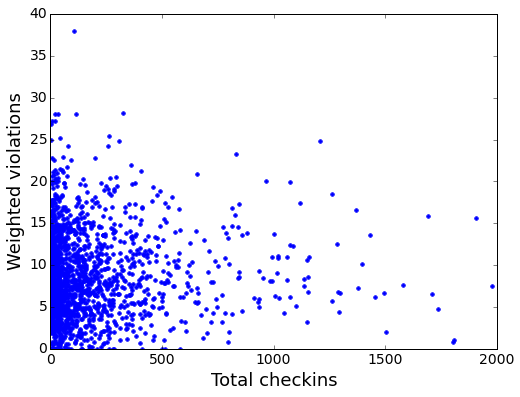

In [21]:
plt.plot(violations_checkins.total_checkins, violations_checkins[('weighted_violations', 'mean')], '.')
plt.xlim(0, 2000)
plt.xlabel('Total checkins')
plt.ylabel('Weighted violations')

In [22]:
from scipy.stats import pearsonr
pearsonr(violations_checkins.total_checkins, violations_checkins[('weighted_violations', 'mean')])

(-0.0011819585238375377, 0.96214447353317434)

There is no correlation between total checkins and violations. The check-in data will be ignored in model building.